In [1]:
import json
import os
import re
import requests
import sys
import warnings

# Add the project root to the Python path
project_root = os.path.abspath(os.path.join(os.path.dirname(__file__), '..', '..'))
sys.path.append(project_root)

from src.utils.helper import load_env

In [44]:
from haystack import Pipeline
from haystack.components.builders import PromptBuilder
from haystack_integrations.components.generators.anthropic import AnthropicGenerator
from haystack_integrations.components.generators.ollama import OllamaGenerator
from haystack.utils import Secret
from typing import List, Dict, Any

In [3]:
# Load environment variables and API keys
warnings.filterwarnings('ignore')
load_env()
ANTHROPIC_API_KEY = os.getenv("ANTHROPIC_API_KEY")
CLIENT_SECRET = os.getenv("WPCOM_CLIENT_SECRET")
ACCESS_TOKEN = os.getenv("WPCOM_ACCESS_TOKEN")

Found .env file at: /Users/firatgelbal/code/misc/a8c-data-blog/.env
load_dotenv() result: True


In [4]:
# Define WordPress.com API constants
AUTHORIZATION_BASE_URL = 'https://public-api.wordpress.com/oauth2/authorize'
TOKEN_URL = 'https://public-api.wordpress.com/oauth2/token'
CLIENT_ID = <CLIENT_ID>
REDIRECT_URI = <REDIRECT_URI>

site_url = "data.blog"

In [5]:
def extract_names(metadata_dict):
    """
    Extracts the names of tags or categories from the metadata dictionary
    returned by the WordPress.com API.

    :param metadata_dict: Dictionary containing tag or category metadata
    :return: List of tag or category names
    """
    return list(metadata_dict.keys())

def load_posts(file_name='posts.json'):
    file_path = os.path.join('..', '..', 'data', file_name)
    with open(file_path, 'r') as f:
        return json.load(f)

def save_posts(posts, file_name='updated_posts.json'):
    file_path = os.path.join('..', '..', 'data', file_name)
    with open(file_path, 'w') as f:
        json.dump(posts, f, indent=2)

In [6]:
posts = load_posts('updated_posts.json')

In [51]:
# Updated taxonomy
CATEGORIES = [
    'Data Engineering', 'Data Science', 'Data Visualization', 'Distributed Work',
    'Experimentation and A/B Testing', 'Network Science', 'Search and Information Retrieval',
    'Machine Learning and AI', 'Automatticians'
]

TAGS = [
    'Data Science', 'Data Engineering', 'Data Visualization', 'Machine Learning',
    'Artificial Intelligence', 'Distributed Work', 'Remote Work', 'Data Analytics',
    'Tech Industry', 'Communication', 'Productivity', 'Automattic', 'WordPress',
    'Semantic Search', 'Diversity and Inclusion', 'Work-Life Balance', 'Career and Professional Development',
    'Books and Reading', 'Learning and Education', 'Data Discoverability', 'Automation',
    'Software Engineering', 'A/B Testing', 'Experimentation', 'Marketing Analytics',
    'Python', 'Data Speaker Series', 'Scientific Communication', 'Bias in AI', 'Data Ethics',
    'Best Practices', 'Causal Inference', 'Technology Trends',
    'Conferences and Events', 'Transparency in Data', 'Data Retention', 'Network Analysis',
    'Open Source', 'Time Series Analysis', 'Deep Learning', 'Surveys and Research Methods',
    'Data Products', 'Elasticsearch', 'Natural Language Processing', 'Meetup',
    'Information Retrieval', 'Social Media Analytics', 'Feature Engineering', 'Missing Data Handling',
    'Pipe', 'API'
]

In [52]:
from typing import List
from pydantic import BaseModel

class PostTaxonomy(BaseModel):
    category: str
    tags: List[str]
    keywords: List[str]

class BlogPostData(BaseModel):
    taxonomy: PostTaxonomy

In [58]:
import json
import pydantic
from pydantic import ValidationError
from typing import Optional, List
from colorama import Fore
from haystack import component

@component
class OutputValidator:
    def __init__(self, pydantic_model: pydantic.BaseModel):
        self.pydantic_model = pydantic_model
        self.iteration_counter = 0

    @component.output_types(valid_replies=List[str], invalid_replies=Optional[List[str]], error_message=Optional[str])
    def run(self, replies: List[str]):
        self.iteration_counter += 1

        try:
            # Attempt to fix common JSON issues
            fixed_reply = self.attempt_json_fix(replies[0])
            output_dict = json.loads(fixed_reply)
            self.pydantic_model.parse_obj(output_dict)
            print(
                Fore.GREEN
                + f"OutputValidator at Iteration {self.iteration_counter}: Valid JSON from LLM - No need for looping: {fixed_reply}"
            )
            return {"valid_replies": [fixed_reply]}

        except (ValueError, ValidationError) as e:
            print(
                Fore.RED
                + f"OutputValidator at Iteration {self.iteration_counter}: Invalid JSON from LLM - Let's try again.\n"
                f"Output from LLM:\n {replies[0]} \n"
                f"Error from OutputValidator: {e}"
            )
            return {"invalid_replies": replies, "error_message": str(e)}

    def attempt_json_fix(self, json_str: str) -> str:
        # Remove any trailing commas before closing braces or brackets
        json_str = re.sub(r',\s*}', '}', json_str)
        json_str = re.sub(r',\s*]', ']', json_str)

        # Ensure the JSON object is properly closed
        if not json_str.strip().endswith('}'):
            json_str = json_str.strip() + '}'

        return json_str

In [62]:
prompt_template = """
Analyze the following blog post and create a complete, valid JSON object with the most appropriate category, up to 5 relevant tags, and 10 specific keywords or phrases that are central to the post's content.

Blog post:
Title: {{title}}
Content: {{content}}

Available categories:
{{categories}}

Available tags:
{{tags}}

Follow this JSON schema, but only return the actual instances without any additional schema definition:
{{schema}}

Make sure your response is a complete, valid JSON object (dict) and not a list. Ensure all opening brackets, braces, and quotes have matching closing ones.
Ensure that the category and tags are from the provided lists only. Keywords can be any relevant terms or phrases from the post.

{% if invalid_replies and error_message %}
  You already created the following output in a previous attempt: {{invalid_replies}}
  However, this doesn't comply with the format requirements from above and triggered this Python exception: {{error_message}}
  Correct the output and try again. Just return the corrected output without any extra explanations.
{% endif %}
"""

prompt_builder = PromptBuilder(template=prompt_template)

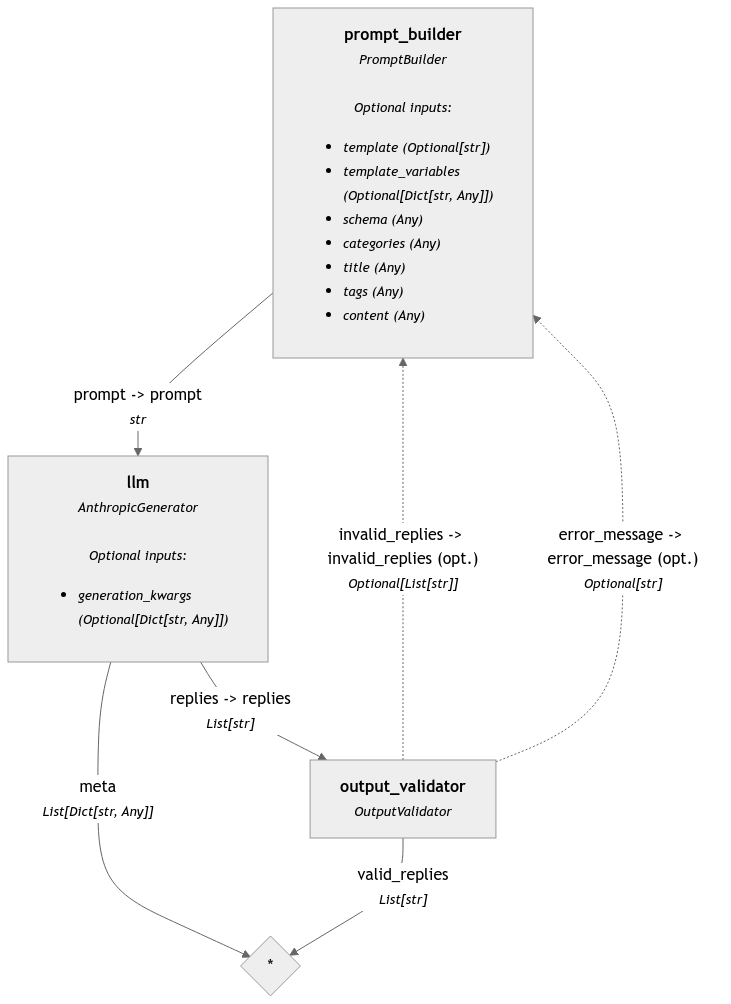

In [63]:
# Initialize the OutputValidator with the Pydantic model
output_validator = OutputValidator(pydantic_model=BlogPostData)

# generator = OllamaGenerator(model="yi-coder:9b",
#                             url = "http://localhost:11434",
#                             generation_kwargs={
#                             "num_predict": 100,
#                             "temperature": 0.7,
#                             })

generator = AnthropicGenerator(Secret.from_env_var("ANTHROPIC_API_KEY"), model="claude-3-5-sonnet-20240620")

pipeline = Pipeline(max_loops_allowed=3)

# Add components to the pipeline
pipeline.add_component(instance=prompt_builder, name="prompt_builder")
pipeline.add_component(instance=generator, name="llm")
pipeline.add_component(instance=output_validator, name="output_validator")

# Connect the components
pipeline.connect("prompt_builder", "llm")
pipeline.connect("llm", "output_validator")
pipeline.connect("output_validator.invalid_replies", "prompt_builder.invalid_replies")
pipeline.connect("output_validator.error_message", "prompt_builder.error_message")

pipeline.show()

In [65]:
for i, post in enumerate(posts):
    print(f"Processing post {i+1}/{len(posts)}: {post['title']}")

    input_dict = {
        "title": post["title"],
        "content": post["content"],
        "categories": CATEGORIES,
        "tags": TAGS,
        "schema": BlogPostData.schema_json()
    }

    result = pipeline.run(data=input_dict)

    if result["output_validator"]["valid_replies"]:
        taxonomy = json.loads(result["output_validator"]["valid_replies"][0])
        print(f"Generated taxonomy: {taxonomy}")
        post['llm_category'] = taxonomy['taxonomy']['category']
        post['llm_tags'] = taxonomy['taxonomy']['tags']
        post['llm_keywords'] = taxonomy['taxonomy']['keywords']
    else:
        print("Failed to generate valid taxonomy after maximum iterations.")

Processing post 1/97: Data Talks &amp; Conferences Recommended by Automatticians
OutputValidator at Iteration 2: Valid JSON from LLM - No need for looping: {
  "taxonomy": {
    "category": "Data Engineering",
    "tags": [
      "Data Science",
      "Conferences and Events",
      "Career and Professional Development",
      "Learning and Education",
      "Tech Industry"
    ],
    "keywords": [
      "PyData Seattle",
      "Airflow Summit",
      "Women in Data Science",
      "Data conferences",
      "Python",
      "Workflow management",
      "Text encoding",
      "Data quality",
      "Data contracts",
      "Continuous learning"
    ]
  }
}
Generated taxonomy: {'taxonomy': {'category': 'Data Engineering', 'tags': ['Data Science', 'Conferences and Events', 'Career and Professional Development', 'Learning and Education', 'Tech Industry'], 'keywords': ['PyData Seattle', 'Airflow Summit', 'Women in Data Science', 'Data conferences', 'Python', 'Workflow management', 'Text encodi

In [66]:
save_posts(posts, 'updated_posts_with_llm_taxonomy.json')

In [73]:
def validate_taxonomy(post, categories, tags):
    # Validate category
    if post['llm_category'] not in categories:
        print(f"Invalid category for post '{post['title']}': {post['llm_category']}")
        post['llm_category'] = None  # or you could set it to a default category

    # Validate tags and remove tag if it's the same as category
    valid_tags = [tag for tag in post['llm_tags'] if tag in tags and tag != post['llm_category']]
    invalid_tags = [tag for tag in post['llm_tags'] if tag not in tags]
    removed_tags = [tag for tag in post['llm_tags'] if tag not in valid_tags]

    if invalid_tags or removed_tags:
        print(f"Removed tags for post '{post['title']}': {removed_tags}")
    post['llm_tags'] = valid_tags

    return post

# Iterate over posts and validate taxonomy
for post in posts:
    post = validate_taxonomy(post, CATEGORIES, TAGS)

# Print summary
print(f"\nValidation complete. Processed {len(posts)} posts.")
print(f"Posts with invalid categories: {sum(1 for post in posts if post['llm_category'] is None)}")
print(f"Posts with removed tags: {sum(1 for post in posts if len(post['llm_tags']) < len(post.get('llm_tags', [])))}")


Removed tags for post 'From Support to Data Science and Analytics: My Journey at Automattic': ['Data Science']
Removed tags for post 'Hack Project: Creating a tool to translate customer feedback into product insights': ['Data Science']
Removed tags for post 'Optimizing Connections at Meetups': ['Distributed Work']
Removed tags for post 'The New Face of Jetpack Stats': ['User Experience', 'Product Development']
Invalid category for post 'Visualizing Diversity at Automattic': Diversity and Inclusion
Removed tags for post 'Women of Datamattic: Madison Swain-Bowden': ['Data Engineering']
Removed tags for post 'Automattic’s First Data+ Meetup': ['Distributed Work']
Removed tags for post 'How to profit from an Analytics Skill Matrix': ['Data Science']
Removed tags for post 'SQL — a Common Language for the Whole Data Team': ['Data Engineering']
Removed tags for post 'Teaching Python to Beginners': ['Data Science']
Removed tags for post 'Boris Gorelik on the biggest missed opportunity in data 

In [81]:
# Save the updated posts
save_posts(posts, 'validated_posts_with_llm_taxonomy.json')

In [85]:
def update_posts(site_url, access_token, posts, log_file='taxonomy_changes.log'):
    api_url = f"https://public-api.wordpress.com/rest/v1.1/sites/{site_url}/posts"

    headers = {
        "Authorization": f"Bearer {access_token}",
        "Content-Type": "application/json"
    }

    with open(log_file, 'w') as log:
        for post in posts:
            if 'llm_category' in post and 'llm_tags' in post:
                post_id = post['ID']
                original_category = list(post['categories'].keys())[0] if post['categories'] else 'None'
                original_tags = list(post['tags'].keys()) if post['tags'] else []

                # Keep original category if llm_category is None
                new_category = post['llm_category'] if post['llm_category'] is not None else original_category

                # Combine llm_tags with original tags that are in TAGS but not in llm_tags
                new_tags = set(post['llm_tags'])
                for tag in original_tags:
                    if tag in TAGS and tag not in new_tags:
                        new_tags.add(tag)
                new_tags = list(new_tags)

                update_data = {
                    "categories": new_category,
                    "tags": new_tags
                }

                try:
                    response = requests.post(f"{api_url}/{post_id}", headers=headers, json=update_data)
                    response.raise_for_status()

                    # Log the changes
                    log.write(f"Post ID: {post_id}\n")
                    log.write(f"Title: {post['title']}\n")
                    log.write(f"Original Category: {original_category} -> New Category: {new_category}\n")
                    log.write(f"Original Tags: {', '.join(original_tags)} -> New Tags: {', '.join(new_tags)}\n")
                    log.write("-" * 50 + "\n")

                    print(f"Updated post {post_id}: {post['title']}")

                except requests.exceptions.RequestException as e:
                    print(f"An error occurred updating post {post_id}: {e}")
                    log.write(f"Error updating post {post_id}: {e}\n")
                    log.write("-" * 50 + "\n")

            else:
                print(f"Skipping post {post['ID']}: Missing LLM-generated taxonomy")

    print(f"Update complete. Changes logged to {log_file}")


In [91]:
update_posts(site_url, ACCESS_TOKEN, posts[])

Updated post 3862: What your neurodivergent colleagues wish you knew
Updated post 3856: From Support to Data Science and Analytics: My Journey at Automattic
Updated post 3841: Hack Project: Creating a tool to translate customer feedback into product insights
Updated post 3804: Hack Project: Tackling FOMO on the P2 Land
Updated post 3731: Optimizing Connections at Meetups
Updated post 3709: Synchronizing Data with Apache Superset: Our Internal Solution
Updated post 3649: The New Face of Jetpack Stats
Updated post 3613: Quest for Efficient AI: An Evaluation of the Vector Database Landscape
Updated post 3580: Visualizing Diversity at Automattic
Updated post 3530: Tips for a healthy work-life balance for people starting at a remote company
Updated post 3520: How to Organize a Data Book Club at Work
Updated post 3506: Women of Datamattic | Menaka Sankaralingam
Updated post 3494: Women of Datamattic: Madison Swain-Bowden
Updated post 3464: Women of Datamattic: Anna Elek
Updated post 3454: Th